In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime #for tensorboard

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

# Clear any logs from previous runs
#rm -rf /logs/fit #buggy

In [2]:
datadir = 'C:/Users/17788/Documents/code/Py/emotions-main/emotions-main/emotions.csv'
data = pd.read_csv(datadir)
#data

In [3]:
#print(data.columns.tolist())

In [4]:
#plot the data to see what it looks like. Looks like csv is [time x features]
#sample = data.loc[:, 'fft_0_b']
#plt.plot(sample)

In [5]:
#data['label'].value_counts()
#re-map the labels onto the labels column
label_map = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
data['label'] = data['label'].replace(label_map)

In [6]:
def preprocess_inputs(df):
    #extract the data and the labels. just the first 1000
    df1 = df.loc[0:1000, 'mean_1_a':'mean_d_4_a'].copy()
    df2 = df.loc[0:1000, 'label'].copy()
    
    y = df2
    X = df1
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

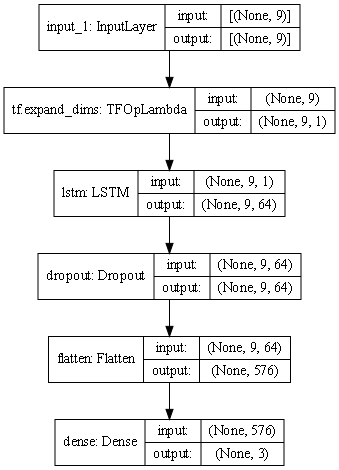

In [8]:
#start defining the model
inputs = tf.keras.Input(shape=(X_train.shape[1],))
expand_dims = tf.expand_dims(inputs, axis=2)
LSTM = tf.keras.layers.LSTM(64, return_sequences=True)(expand_dims)
dropout = tf.keras.layers.Dropout(0.4)(LSTM)
flatten = tf.keras.layers.Flatten()(dropout)
outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
#print(model.summary())
tf.keras.utils.plot_model(model = model , rankdir="UD", dpi=72, show_shapes=True)

In [9]:
#opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#for tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=64,
    epochs=100,
    callbacks=[
        tensorboard_callback,
        #tf.keras.callbacks.LearningRateScheduler(
        #lambda epoch: 1e-3 * 10 ** (epoch / 30)
        #)
    ]
)

Epoch 1/100
9/9 [==============================] - 9s 515ms/step - loss: 0.9399 - accuracy: 0.5724 - val_loss: 0.7350 - val_accuracy: 0.7357
Epoch 2/100
9/9 [==============================] - 0s 19ms/step - loss: 0.7087 - accuracy: 0.7094 - val_loss: 0.5998 - val_accuracy: 0.7786
Epoch 3/100
9/9 [==============================] - 0s 20ms/step - loss: 0.5572 - accuracy: 0.7824 - val_loss: 0.5229 - val_accuracy: 0.7786
Epoch 4/100
9/9 [==============================] - 0s 19ms/step - loss: 0.4983 - accuracy: 0.7955 - val_loss: 0.4692 - val_accuracy: 0.7786
Epoch 5/100
9/9 [==============================] - 0s 20ms/step - loss: 0.4059 - accuracy: 0.8380 - val_loss: 0.4230 - val_accuracy: 0.8286
Epoch 6/100
9/9 [==============================] - 0s 19ms/step - loss: 0.3600 - accuracy: 0.8635 - val_loss: 0.3884 - val_accuracy: 0.8429
Epoch 7/100
9/9 [==============================] - 0s 19ms/step - loss: 0.2845 - accuracy: 0.9127 - val_loss: 0.3595 - val_accuracy: 0.8500
Epoch 8/100
9/9 [==

In [ ]:
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

In [ ]:
y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_map.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_map.keys())
plt.yticks(np.arange(3) + 0.5, label_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
learning_rates = 1e-3 * (10 ** (np.arange(100) / 30))
plt.semilogx(
    learning_rates, 
    history.history['loss'], 
    lw=3, color='#000'
)
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14);